In [1]:
from lib.meshes import *

In [2]:
mesh = trimesh.load("meshes/rectangle.obj")

In [18]:
a, b, c, d, e = get_progressive_dataset(mesh, 100, 64, 0, 1500, 160, 40)

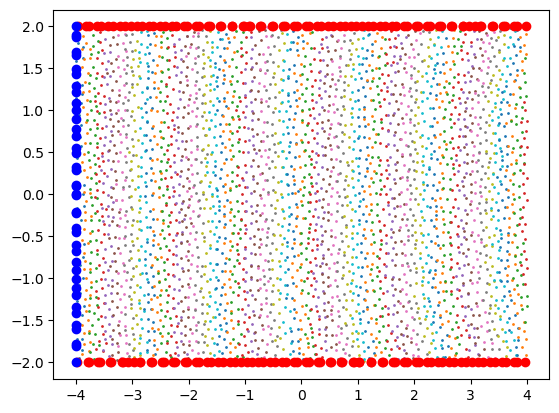

In [19]:
prev = 0
for x in d:
    plt.scatter(a[prev:x,0],a[prev:x,1],s=1)
    prev = x
plt.scatter(b[:,0],b[:,1],c='r')
plt.scatter(c[:,0],c[:,1],c='b')
plt.show()

In [12]:
import torch

In [22]:
initial_value = np.expand_dims(np.exp(-4*c[:,1]**2),axis=1)
boundary_value = np.zeros_like(b[:,0:1])

In [27]:
print(a.shape)
print(b.shape, boundary_value.shape)
print(c.shape, initial_value.shape)
print(d)

(3479, 2)
(160, 2) (160, 1)
(40, 2) (40, 1)
[46, 101, 161, 216, 273, 328, 384, 436, 493, 544, 599, 655, 713, 771, 826, 885, 942, 998, 1052, 1108, 1168, 1223, 1278, 1332, 1385, 1440, 1490, 1544, 1589, 1639, 1694, 1750, 1805, 1860, 1918, 1977, 2032, 2086, 2143, 2195, 2250, 2304, 2359, 2414, 2469, 2525, 2580, 2633, 2688, 2744, 2797, 2851, 2904, 2958, 3014, 3069, 3123, 3181, 3235, 3294, 3354, 3407, 3452, 3479]


In [35]:
bulk_points = (
    torch.tensor(a[:,1:2],dtype=torch.float32, requires_grad=True),
    torch.tensor(a[:,0:1],dtype=torch.float32, requires_grad=True)
)
boundary_points = (
    torch.tensor(b[:,1:2],dtype=torch.float32, requires_grad=True),
    torch.tensor(b[:,0:1],dtype=torch.float32, requires_grad=True),
    torch.tensor(boundary_value,dtype=torch.float32),
)
initial_points = (
    torch.tensor(c[:,1:2],dtype=torch.float32, requires_grad=True),
    torch.tensor(c[:,0:1],dtype=torch.float32, requires_grad=True),
    torch.tensor(initial_value,dtype=torch.float32),
)
data = [
    bulk_points,
    boundary_points,
    initial_points,
    d
]

In [31]:
import pickle

In [36]:
with open("data", "wb") as f:
    pickle.dump(data, f)

In [34]:
with open("data", "rb") as f:
    casf = pickle.load(f)

# Cose

In [21]:
mesh = load_mesh('meshes/holes.obj')

In [22]:
def generate_barycentric_grid_inside_mesh_with_margin(mesh: trimesh.Trimesh, N: int, min_dist: float = 0.01) -> np.ndarray:
    import numpy as np
    from shapely.geometry import LineString, Point
    from shapely.strtree import STRtree

    # Step 1: crea le LineString
    boundary_edges = get_topological_boundary(mesh)
    edge_geoms = [LineString(mesh.vertices[edge][:, :2]) for edge in boundary_edges]

    # Step 2: costruisci STRtree con riferimenti agli oggetti veri
    tree = STRtree(edge_geoms)

    # Step 3: prepara coordinate baricentriche regolari
    bary_coords = np.array([
        [i / N, j / N, 1 - i / N - j / N]
        for i in range(N + 1)
        for j in range(N + 1 - i)
    ])

    points = []

    # Step 4: scorri i triangoli
    for face in mesh.faces:
        v0, v1, v2 = mesh.vertices[face][:, :2]
        tri_pts = (
            bary_coords[:, 0:1] * v0 +
            bary_coords[:, 1:2] * v1 +
            bary_coords[:, 2:3] * v2
        )

        for pt in tri_pts:
            p = Point(pt)
            near_edges = tree.query(p.buffer(min_dist))
            if all(p.distance(edge_geoms[e]) > min_dist for e in near_edges):
                points.append(pt)

    return np.array(points)


In [26]:
boundary = get_topological_boundary(mesh)
points_b = sample_points_on_boundary(mesh,boundary,2000)
boundary_x = points_b[:,0:1]
boundary_y = points_b[:,1:2]
points = generate_barycentric_grid_inside_mesh_with_margin(mesh,2,0.006)
bulk_x = points[:,0:1]
bulk_y = points[:,1:2]
print(points.shape, points_b.shape)

(9504, 2) (2000, 2)


In [187]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Scatter dei punti interni
scatter_interni = go.Scatter(
    x=bulk_t,
    y=bulk_x,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Punti interni'
)

# Scatter dei punti al bordo con colorazione
scatter_bordo = go.Scatter(
    x=boundary_t,
    y=boundary_x,
    mode='markers',
    marker=dict(size=3, color=boundary_values, colorscale='Viridis', colorbar=dict(title='Boundary Value')),
    name='Punti al bordo'
)

scatter_bordo = go.Scatter(
    x=initial_t,
    y=initial_x,
    mode='markers',
    marker=dict(size=3, color=initial_values, colorscale='Viridis', colorbar=dict(title='Boundary Value')),
    name='Punti iniziali'
)

# Crea la figura
fig = go.Figure(data=[scatter_interni, scatter_bordo])

fig.update_layout(
    title="Visualizzazione interattiva dei punti",
    xaxis_title="x",
    yaxis_title="y",
    height=300,
    width=600,
    showlegend=True
)

fig.show()

In [27]:
boundary_value = np.zeros_like(boundary_x)

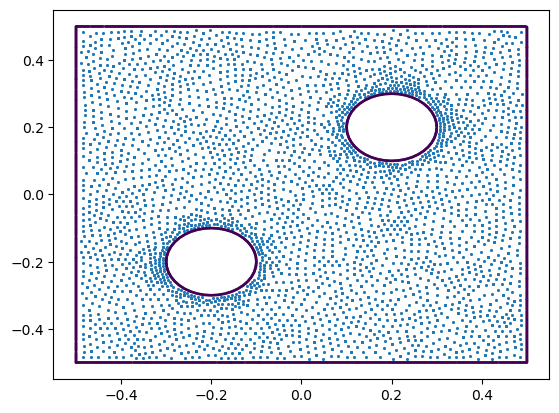

In [28]:
plt.scatter(bulk_x, bulk_y, s=1)
plt.scatter(boundary_x, boundary_y, s=1, c=boundary_value)
plt.show()

In [29]:
print(bulk_x.shape, bulk_y.shape)
print(boundary_x.shape, boundary_y.shape, boundary_value.shape)
bulk_data = (bulk_x, bulk_y)
boundary_data = (boundary_x, boundary_y, boundary_value)
data = {
    'bulk': bulk_data,
    'boundary': boundary_data
}

(9504, 1) (9504, 1)
(2000, 1) (2000, 1) (2000, 1)


In [30]:
import pickle
with open('meshes/holes_laplace.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
import pickle
with open('meshes/circle_eikonal.pkl', 'wb') as f:
    pickle.dump(data, f)

In [237]:
mesh = trimesh.load('meshes/eikonal_circle.obj')
print(mesh.metadata)

{'processed': True}


# Holes

In [15]:
mesh = load_mesh('meshes/holes.obj')

In [16]:
bulk_points, boundary_points, indices, scheduler = get_progressive_dataset(mesh, 100, 4, 4000, 1000)

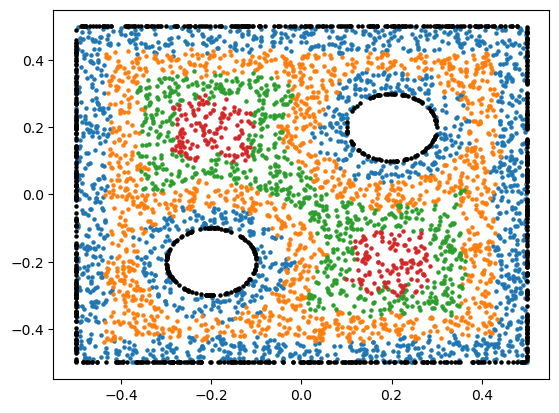

In [17]:
prev = 0
for i in indices:
    plt.scatter(bulk_points[prev:i,0],bulk_points[prev:i,1],s=5)
    prev = i
plt.scatter(boundary_points[:,0], boundary_points[:,1], s=5, c='k')
plt.show()

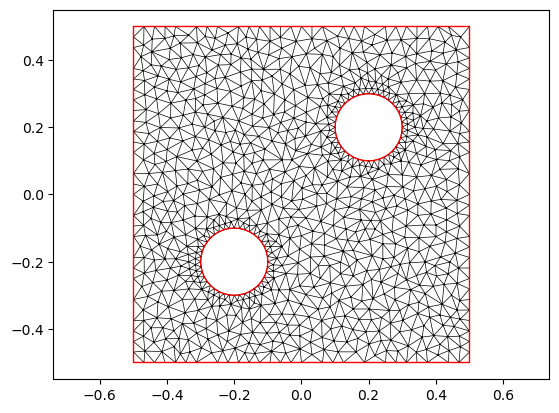

In [18]:
visualize_mesh(mesh, show_boundary=True, boundary_mask=mask)

In [21]:
distances = get_geodesic_distance(mesh)

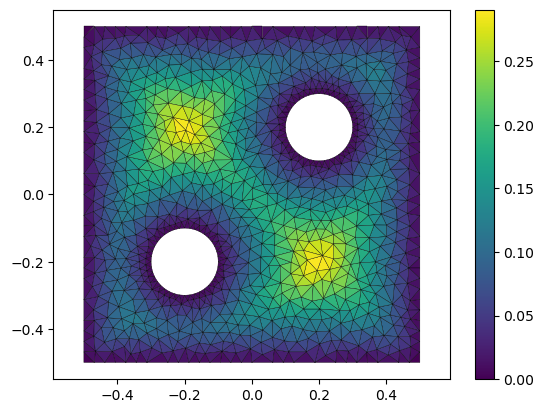

In [22]:
visualize_scalar_field(mesh, distances)

# Rectangle

In [2]:
mesh = load_mesh('meshes/rectangle.obj')

In [7]:
def mask(mesh, edges) -> np.ndarray:
    xs = mesh.vertices[:, 0]
    keep = ~((xs[edges[:, 0]] == 4.0) & (xs[edges[:, 1]] == 4.0))
    return edges[keep]

In [8]:
bulk_points, boundary_points, indices, scheduler = get_progressive_dataset(mesh, 100, 4, 4000, 1000, mask)

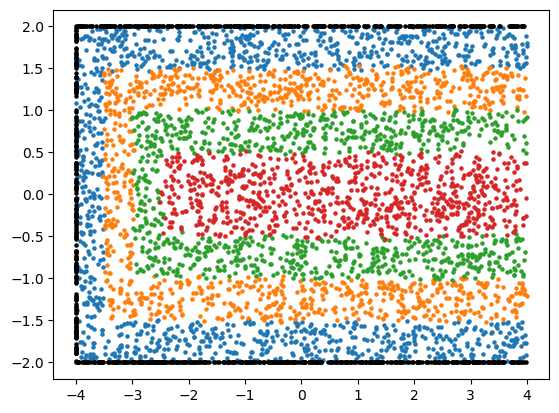

In [9]:
prev = 0
for i in indices:
    plt.scatter(bulk_points[prev:i,0],bulk_points[prev:i,1],s=5)
    prev = i
plt.scatter(boundary_points[:,0], boundary_points[:,1], s=5, c='k')
plt.show()

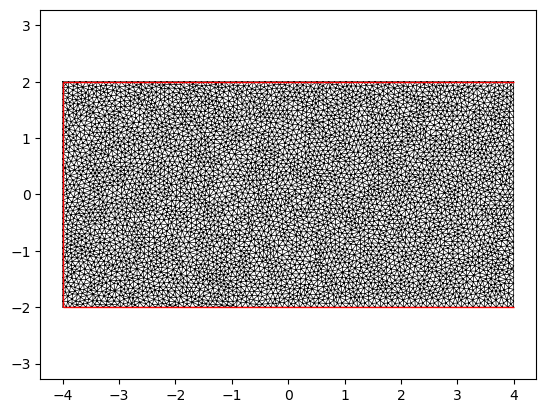

In [10]:
visualize_mesh(mesh, show_boundary=True, boundary_mask=mask)

In [13]:
distances = get_geodesic_distance(mesh, boundary_mask=mask)

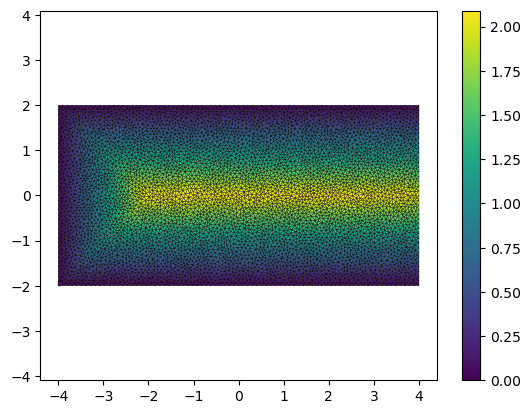

In [14]:
visualize_scalar_field(mesh, distances)

# Generate meshes

In [ ]:
import numpy as np
import triangle as tr
import trimesh

# Funzione per creare un cerchio con n punti
def create_circle(center, radius, n_points=40):
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    return np.stack([center[0] + radius * np.cos(theta),
                     center[1] + radius * np.sin(theta)], axis=1)

# 1. Geometria: rettangolo con due buchi circolari
# Contorno esterno (rettangolo)
outer = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

# Due buchi circolari
hole1 = create_circle(center=[0.3, 0.3], radius=0.1)
hole2 = create_circle(center=[0.7, 0.7], radius=0.1)

# Tutti i punti
points = np.vstack([outer, hole1, hole2])

# Segmenti per contorno esterno
segments = [[i, (i + 1) % 4] for i in range(4)]

# Segmenti per il primo buco
offset1 = len(outer)
segments += [[offset1 + i, offset1 + (i + 1) % len(hole1)] for i in range(len(hole1))]

# Segmenti per il secondo buco
offset2 = offset1 + len(hole1)
segments += [[offset2 + i, offset2 + (i + 1) % len(hole2)] for i in range(len(hole2))]

# Punti interni per identificare i buchi
holes = [[0.3, 0.3], [0.7, 0.7]]

# Dizionario per triangolazione
A = {'vertices': points, 'segments': segments, 'holes': holes}

# 2. Triangolazione con qualità (p), angolo minimo 30 (q30), area massima 0.005 (a0.005)
B = tr.triangulate(A, 'pq30a0.001')

# 3. Esporta in .obj usando trimesh
mesh = trimesh.Trimesh(vertices=B['vertices'], faces=B['triangles'])
mesh.export('mesh_with_two_holes.obj')

print("Mesh salvata come 'mesh_with_two_holes.obj'")

Mesh salvata come 'mesh_with_two_holes.obj'


In [22]:
import triangle as tr
import matplotlib.pyplot as plt

# Definisci i vertici della forma a L (in senso antiorario)
points = [
    [0, 0],     # 0
    [2, 0],     # 1
    [2, 1],     # 2
    [1, 1],     # 3
    [1, 2],     # 4
    [0, 2],     # 5
]

# Definisci i segmenti tra i punti (bordo)
segments = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5, 0]
]

# Prepara input per triangle
A = {
    'vertices': points,
    'segments': segments
}

# Esegui triangolazione con i parametri richiesti
# 'p' = conserva segmenti, 'q30' = qualità (angolo minimo 30°), 'a0.001' = area max triangolo 0.001
B = tr.triangulate(A, 'pq30a0.001')

mesh = trimesh.Trimesh(vertices=B['vertices'], faces=B['triangles'])
mesh.export('L.obj')


'# https://github.com/mikedh/trimesh\nv 0.00000000 0.00000000\nv 2.00000000 0.00000000\nv 2.00000000 1.00000000\nv 1.00000000 1.00000000\nv 1.00000000 2.00000000\nv 0.00000000 2.00000000\nv 0.80742730 1.53411172\nv 1.00000000 1.50000000\nv 0.97293461 1.92187500\nv 0.50000000 2.00000000\nv 1.00000000 1.62500000\nv 0.93183477 1.57189527\nv 0.00000000 1.00000000\nv 1.00000000 1.75000000\nv 0.94003284 1.50357572\nv 1.00000000 1.68750000\nv 0.90545810 1.54961052\nv 1.00000000 1.59375000\nv 0.90046544 1.58227227\nv 0.86106076 1.56436256\nv 0.90140606 1.76808984\nv 0.96563728 1.56516536\nv 0.94437040 1.64621414\nv 0.97863400 1.71875000\nv 0.85451552 1.63433405\nv 0.87202996 1.70923755\nv 0.96297620 1.75238452\nv 0.75000000 2.00000000\nv 0.82583688 1.68053930\nv 0.95642401 1.68809409\nv 1.00000000 1.87500000\nv 0.96829906 1.85937500\nv 0.91775606 1.61850797\nv 0.78750200 1.72492114\nv 0.88953607 1.64430713\nv 0.83854869 1.52566831\nv 0.95805369 1.79687500\nv 0.97175763 1.82420216\nv 0.90454553

In [12]:
from lib.meshes import visualize_mesh

import numpy as np
import trimesh
import triangle as tr

def create_quality_circle_mesh(radius=1.0, segments=64, max_area=0.01, min_angle=30):
    # 1) Genera vertici sul bordo del cerchio
    theta = np.linspace(0, 2*np.pi, segments, endpoint=False)
    verts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * radius

    # 2) Definisci i segmenti (PSLG) che connettono i vertici consecutivi
    segs = np.vstack([
        np.arange(segments), 
        np.roll(np.arange(segments), -1)
    ]).T

    # 3) Prepara il dizionario per triangle
    A = {
        'vertices': verts,
        'segments': segs
    }

    # 4) Triangola con quality meshing:
    #    p = triangola un PSLG
    #    q30 = angolo minore a 30°
    #    a0.001 = area massima di ciascun triangolo = 0.001
    opts = f"pq{min_angle}a{max_area}"
    B = tr.triangulate(A, opts)

    # 5) Ricostruisci un Trimesh da B['vertices'] e B['triangles']
    mesh = trimesh.Trimesh(
        vertices=B['vertices'],
        faces=B['triangles'],
        process=False  # evita ricalcoli automatici
    )
    return mesh

# --- Esempio d’uso ---
mesh = create_quality_circle_mesh(radius=2.0, segments=128, max_area=0.01, min_angle=30)

mesh.export('meshes/circle.obj')


'# https://github.com/mikedh/trimesh\nv 2.00000000 0.00000000\nv 1.99759091 0.09813535\nv 1.99036945 0.19603428\nv 1.97835302 0.29346095\nv 1.96157056 0.39018064\nv 1.94006251 0.48596036\nv 1.91388067 0.58056935\nv 1.88308813 0.67377971\nv 1.84775907 0.76536686\nv 1.80797859 0.85511019\nv 1.76384253 0.94279347\nv 1.71545722 1.02820549\nv 1.66293922 1.11114047\nv 1.60641506 1.19139861\nv 1.54602091 1.26878657\nv 1.48190225 1.34311791\nv 1.41421356 1.41421356\nv 1.34311791 1.48190225\nv 1.26878657 1.54602091\nv 1.19139861 1.60641506\nv 1.11114047 1.66293922\nv 1.02820549 1.71545722\nv 0.94279347 1.76384253\nv 0.85511019 1.80797859\nv 0.76536686 1.84775907\nv 0.67377971 1.88308813\nv 0.58056935 1.91388067\nv 0.48596036 1.94006251\nv 0.39018064 1.96157056\nv 0.29346095 1.97835302\nv 0.19603428 1.99036945\nv 0.09813535 1.99759091\nv 0.00000000 2.00000000\nv -0.09813535 1.99759091\nv -0.19603428 1.99036945\nv -0.29346095 1.97835302\nv -0.39018064 1.96157056\nv -0.48596036 1.94006251\nv -0.58

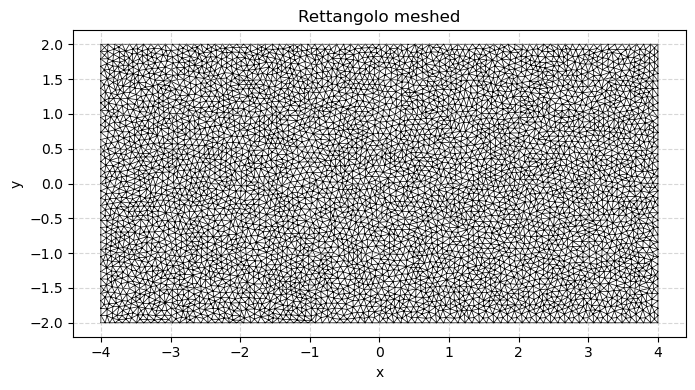

In [1]:
import numpy as np
import trimesh
import triangle as tr
import matplotlib.pyplot as plt

def create_quality_rectangle_mesh(width=2.0, height=1.0, segments_x=20, segments_y=10, max_area=0.01, min_angle=30):
    # 1) Genera vertici sul bordo del rettangolo
    x = np.linspace(-width / 2, width / 2, segments_x)
    y = np.linspace(-height / 2, height / 2, segments_y)
    
    # Ordine: bottom, right, top, left
    bottom = np.stack([x, np.full_like(x, -height/2)], axis=1)
    right = np.stack([np.full_like(y, width/2), y], axis=1)[1:]  # evita duplicati
    top = np.stack([x[::-1], np.full_like(x, height/2)], axis=1)[1:]  # evita duplicati
    left = np.stack([np.full_like(y, -width/2), y[::-1]], axis=1)[1:]  # evita duplicati

    verts = np.vstack([bottom, right, top, left])
    n = len(verts)

    # 2) Segmenti tra punti consecutivi
    segs = np.column_stack([np.arange(n), np.roll(np.arange(n), -1)])

    # 3) Input per triangle
    A = {
        'vertices': verts,
        'segments': segs
    }

    # 4) Opzioni di meshing
    opts = f"pq{min_angle}a{max_area}"
    B = tr.triangulate(A, opts)

    # 5) Crea mesh finale
    mesh = trimesh.Trimesh(
        vertices=B['vertices'],
        faces=B['triangles'],
        process=False
    )
    return mesh

# Esempio d’uso
mesh = create_quality_rectangle_mesh(width=8.0, height=4.0, segments_x=40, segments_y=20, max_area=0.005, min_angle=30)

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_trimesh_2d(mesh):
    """Visualizza una mesh 2D di tipo trimesh usando matplotlib."""
    verts = mesh.vertices
    tris = mesh.faces

    tri = Triangulation(verts[:, 0], verts[:, 1], tris)

    plt.figure(figsize=(8, 4))
    plt.triplot(tri, color='black', linewidth=0.5)
    plt.gca().set_aspect('equal')
    plt.title("Rettangolo meshed")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_trimesh_2d(mesh)

In [2]:
mesh.export('meshes/rectangle.obj')

'# https://github.com/mikedh/trimesh\nv -4.00000000 -2.00000000\nv -3.79487179 -2.00000000\nv -3.58974359 -2.00000000\nv -3.38461538 -2.00000000\nv -3.17948718 -2.00000000\nv -2.97435897 -2.00000000\nv -2.76923077 -2.00000000\nv -2.56410256 -2.00000000\nv -2.35897436 -2.00000000\nv -2.15384615 -2.00000000\nv -1.94871795 -2.00000000\nv -1.74358974 -2.00000000\nv -1.53846154 -2.00000000\nv -1.33333333 -2.00000000\nv -1.12820513 -2.00000000\nv -0.92307692 -2.00000000\nv -0.71794872 -2.00000000\nv -0.51282051 -2.00000000\nv -0.30769231 -2.00000000\nv -0.10256410 -2.00000000\nv 0.10256410 -2.00000000\nv 0.30769231 -2.00000000\nv 0.51282051 -2.00000000\nv 0.71794872 -2.00000000\nv 0.92307692 -2.00000000\nv 1.12820513 -2.00000000\nv 1.33333333 -2.00000000\nv 1.53846154 -2.00000000\nv 1.74358974 -2.00000000\nv 1.94871795 -2.00000000\nv 2.15384615 -2.00000000\nv 2.35897436 -2.00000000\nv 2.56410256 -2.00000000\nv 2.76923077 -2.00000000\nv 2.97435897 -2.00000000\nv 3.17948718 -2.00000000\nv 3.38

In [9]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

mesh = trimesh.load('meshes/holes.obj')
#mesh.vertices = mesh.vertices-0.5

def plot_trimesh_2d(mesh):
    """Visualizza una mesh 2D di tipo trimesh usando matplotlib."""
    verts = mesh.vertices
    tris = mesh.faces

    tri = Triangulation(verts[:, 0], verts[:, 1], tris)

    plt.figure(figsize=(8, 4))
    plt.triplot(tri, color='black', linewidth=0.5)
    plt.gca().set_aspect('equal')
    plt.title("Rettangolo meshed")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

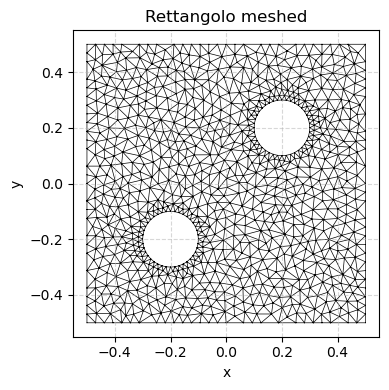

In [10]:
plot_trimesh_2d(mesh)